In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [16]:
df = pd.read_csv("../dataa/electricity_features_hourly.csv")

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

df.head()


,consumption,hour,dayofweek,month,is_weekend,hour_sin,hour_cos,month_sin,month_cos,lag_1h,lag_24h,lag_168h,rolling_mean_24h,rolling_mean_7d,is_holiday,temperature,humidity
Date,,,,,,,,,,,,,,,,,
2011-01-08 00:00:00,86403.301624,0,5,1,1,0.000000,1.000000,0.5,0.866025,111609.594412,85716.807571,51764.567568,120015.695552,112329.611000,0,14.0,87.0
2011-01-08 01:00:00,72534.984171,1,5,1,1,0.258819,0.965926,0.5,0.866025,86403.301624,73297.911807,66344.627687,119983.906900,112366.458360,0,14.3,85.0
2011-01-08 02:00:00,69325.030607,2,5,1,1,0.500000,0.866025,0.5,0.866025,72534.984171,70543.526944,65981.054883,119933.136219,112386.362977,0,14.5,84.0
2011-01-08 03:00:00,68554.184257,3,5,1,1,0.707107,0.707107,0.5,0.866025,69325.030607,70242.037536,66576.533566,119862.809000,112398.134708,0,14.5,84.0
2011-01-08 04:00:00,69033.522311,4,5,1,1,0.866025,0.500000,0.5,0.866025,68554.184257,68884.017033,64963.552675,119869.038386,112422.360717,0,14.6,84.0


In [17]:
target = "consumption"

exog_features = [
    "temperature",
    "humidity",
    "is_holiday",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "month_sin", 
    "month_cos"
]

y = df[target]
X = df[exog_features]

In [18]:
train_size = int(len(df) * 0.8)

y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]


In [19]:
model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_result = model.fit(disp=False)

print(sarimax_result.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        consumption   No. Observations:                27916
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -278154.455
Date:                            Tue, 16 Dec 2025   AIC                         556334.911
Time:                                    14:40:58   BIC                         556441.967
Sample:                                01-08-2011   HQIC                        556369.382
                                     - 03-16-2014                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature   693.5220    124.063      5.590      0.000     450.363     936.681
humidity       46.4736     14.72

In [20]:
pred = sarimax_result.predict(
    start=y_test.index[0],
    end=y_test.index[-1],
    exog=X_test
)


In [21]:
from sklearn.metrics import mean_absolute_error ,mean_squared_error

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")


MAE: 75009.800
RMSE: 99054.901


In [22]:
results = pd.DataFrame({
    "actual": y_test,
    "predicted": pred
})

results.head()


,actual,predicted
2014-03-16 04:00:00,107756.532059,114711.385123
2014-03-16 05:00:00,111525.398404,121298.299175
2014-03-16 06:00:00,126897.471138,138137.301186
2014-03-16 07:00:00,140579.737442,154207.298712
2014-03-16 08:00:00,149643.211466,162622.819531


In [23]:
daily_results = results.resample("D").sum()
daily_results.head()


,actual,predicted
2014-03-16,4.107518e+06,4.195864e+06
2014-03-17,4.617167e+06,4.799660e+06
2014-03-18,4.634251e+06,4.793613e+06
2014-03-19,4.663809e+06,4.824473e+06
2014-03-20,4.663008e+06,4.840124e+06


In [24]:
daily_mae = mean_absolute_error(
    daily_results["actual"],
    daily_results["predicted"]
)

daily_rmse = np.sqrt(
    mean_squared_error(
        daily_results["actual"],
        daily_results["predicted"]
    )
)

print(f"Daily MAE: {daily_mae:.0f}")
print(f"Daily RMSE: {daily_rmse:.0f}")


Daily MAE: 1577697
Daily RMSE: 2251694


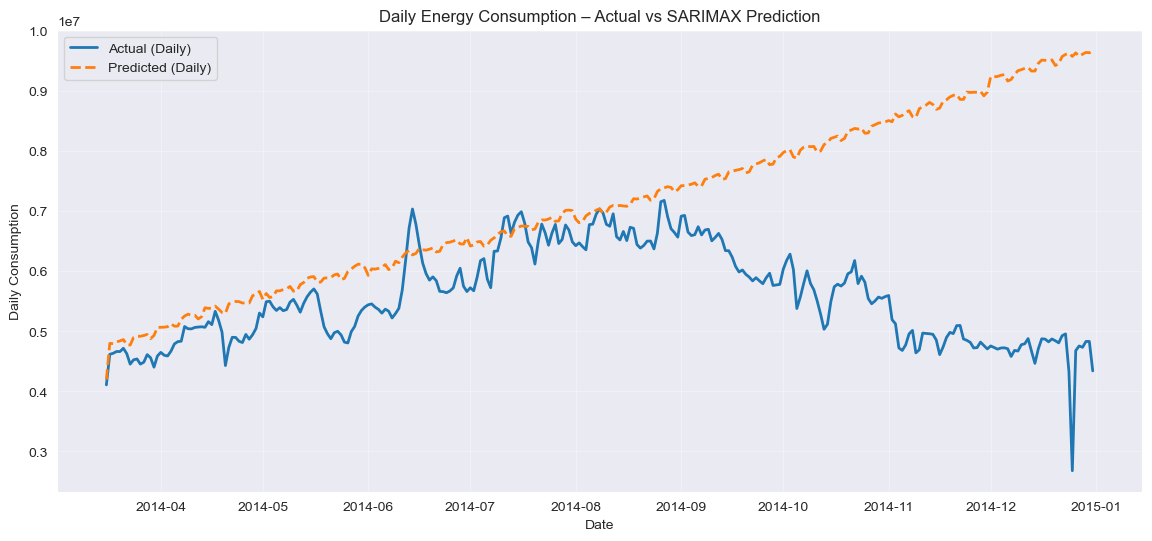

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(
    daily_results.index,
    daily_results["actual"],
    label="Actual (Daily)",
    linewidth=2
)
plt.plot(
    daily_results.index,
    daily_results.loc['2014']["predicted"],
    label="Predicted (Daily)",
    linestyle="--",
    linewidth=2
)

plt.title("Daily Energy Consumption – Actual vs SARIMAX Prediction")
plt.xlabel("Date")
plt.ylabel("Daily Consumption")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
